In [1]:
%%capture
import stata_setup, os
if os.name == 'nt':
    stata_setup.config('C:/Program Files/Stata17/','mp')
else:
    stata_setup.config('/usr/local/stata17','mp')

In [2]:
%%stata -qui

use "../data/data", clear
rename log_flesch_kincaid_grade_level FKG
quietly tabulate year, generate(y_)
quietly tabulate cluster, generate(c_)

local journals  ecm jpe qje res  //AER based category

local jel_imp a_imp b_imp c_imp  e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // D JEL based case

## Logistic Regression

Let ```FKG_01``` be a binary variable indicating that an article's abstract readability is among the 10% highest in the Flesch Kincaid grade level scale.

In [3]:
%%stata -qui
summarize flesch_kincaid_grade_level, detail
local cutoff = r(p90)
gen int FKG_01 = (flesch_kincaid_grade_level >= `cutoff')

In [4]:
%stata list FKG_01 log_num_authors log_num_pages both_genders prop_women jel_flag in 1/10, clean


       FKG_01   log_n~rs   log_~ges   both_g~s   prop_w~n   jel_flag  
  1.        0   .6931472   2.639057          0          0          1  
  2.        1   .6931472    2.70805          0          0          1  
  3.        0   1.098612   3.258096          0          0          1  
  4.        1          0   3.091043          0          0          1  
  5.        1          0   3.496508          0          0          1  
  6.        0          0   2.772589          0          0          1  
  7.        0   1.098612   2.890372          0          0          1  
  8.        1   .6931472   3.295837          0          0          1  
  9.        0   .6931472   2.833213          0          0          1  
 10.        0   .6931472   3.091043          0          0          1  


### Variable Preparation

We now utilize ```Stata``` capabilities to automatically identify ```continuous``` as well as ```dummy``` variables in the data set.

In [5]:
%%stata
#delimit ;
vl set log_num_authors log_num_pages both_genders prop_women
       `journals' `jel_imp' y_2-y_20  c_2-c_215 jel_flag
       , dummy clear nonotes;
#delimit cr


. #delimit ;
delimiter now ;
. vl set log_num_authors log_num_pages both_genders prop_women
>        `journals' `jel_imp' y_2-y_20  c_2-c_215 jel_flag
>        , dummy clear nonotes;

-------------------------------------------------------------------------------
                  |                      Macro's contents
                  |------------------------------------------------------------
Macro             |  # Vars   Description
------------------+------------------------------------------------------------
System            |
  $vldummy        |     258   0/1 variables
  $vlcategorical  |       0   categorical variables
  $vlcontinuous   |       3   continuous variables
  $vluncertain    |       0   perhaps continuous, perhaps categorical variables
  $vlother        |       0   all missing or constant variables
-------------------------------------------------------------------------------

. #delimit cr
delimiter now cr
. 


We manipulate these variable lists to create two lists of variables: (1) ```baseline``` which contains a mixture of continous as well as dummy variables that we would like to control for, and (2) ```mfe``` which is the list of all other indicator variables that are not of interest but we would like to control for.

In [6]:
%%stata -qui
#delimit ;
vl create fe = vldummy - (both_genders jel_flag);
vl substitute mfe = i.fe;
vl create controls = vlcontinuous - (prop_women);
vl create controls_dummy = (both_genders jel_flag);
vl substitute baseline = i.controls_dummy controls;
vl rebuild;
#delimit cr

In [7]:
%%stata
display "$baseline"
display "$mfe"


. display "$baseline"
i.both_genders i.jel_flag log_num_pages log_num_authors

. display "$mfe"
i.ecm i.jpe i.qje i.res i.a_imp i.b_imp i.c_imp i.e_imp i.f_imp i.g_imp i.h_imp
>  i.i_imp i.j_imp i.k_imp i.l_imp i.m_imp i.n_imp i.o_imp i.p_imp i.q_imp i.r_
> imp i.y_imp i.z_imp i.y_2 i.y_3 i.y_4 i.y_5 i.y_6 i.y_7 i.y_8 i.y_9 i.y_10 i.
> y_11 i.y_12 i.y_13 i.y_14 i.y_15 i.y_16 i.y_17 i.y_18 i.y_19 i.y_20 i.c_2 i.c
> _3 i.c_4 i.c_5 i.c_6 i.c_7 i.c_8 i.c_9 i.c_10 i.c_11 i.c_12 i.c_13 i.c_14 i.c
> _15 i.c_16 i.c_17 i.c_18 i.c_19 i.c_20 i.c_21 i.c_22 i.c_23 i.c_24 i.c_25 i.c
> _26 i.c_27 i.c_28 i.c_29 i.c_30 i.c_31 i.c_32 i.c_33 i.c_34 i.c_35 i.c_36 i.c
> _37 i.c_38 i.c_39 i.c_40 i.c_41 i.c_42 i.c_43 i.c_44 i.c_45 i.c_46 i.c_47 i.c
> _48 i.c_49 i.c_50 i.c_51 i.c_52 i.c_53 i.c_54 i.c_55 i.c_56 i.c_57 i.c_58 i.c
> _59 i.c_60 i.c_61 i.c_62 i.c_63 i.c_64 i.c_65 i.c_66 i.c_67 i.c_68 i.c_69 i.c
> _70 i.c_71 i.c_72 i.c_73 i.c_74 i.c_75 i.c_76 i.c_77 i.c_78 i.c_79 i.c_80 i.c
> _81 i.c_82 i.c_83 i.c

In [8]:
%%stata -qui
#delimit ;
logit FKG_01 prop_women $baseline $mfe, vce(cluster cluster) nolog;
#delimit cr

In [9]:
%%stata
estimates table, keep(log_num_authors log_num_pages 1.both_genders prop_women) b(%5.4f) star varwidth(25)


----------------------------------------
                 Variable |   Active    
--------------------------+-------------
          log_num_authors | -0.2194***  
            log_num_pages |  0.4182***  
           1.both_genders |  0.2597*    
               prop_women | -0.5166**   
----------------------------------------
Legend: * p<0.05; ** p<0.01; *** p<0.001


In [10]:
%stata estat class


Logistic model for FKG_01

              -------- True --------
Classified |         D            ~D  |      Total
-----------+--------------------------+-----------
     +     |        25            16  |         41
     -     |       463          4045  |       4508
-----------+--------------------------+-----------
   Total   |       488          4061  |       4549

Classified + if predicted Pr(D) >= .5
True D defined as FKG_01 != 0
--------------------------------------------------
Sensitivity                     Pr( +| D)    5.12%
Specificity                     Pr( -|~D)   99.61%
Positive predictive value       Pr( D| +)   60.98%
Negative predictive value       Pr(~D| -)   89.73%
--------------------------------------------------
False + rate for true ~D        Pr( +|~D)    0.39%
False - rate for true D         Pr( -| D)   94.88%
False + rate for classified +   Pr(~D| +)   39.02%
False - rate for classified -   Pr( D| -)   10.27%
--------------------------------------------------

### _Average_ Marginal Effects

In [11]:
%%stata
margins, dydx(log_num_authors log_num_pages both_genders prop_women)


Average marginal effects                                 Number of obs = 4,549
Model VCE: Robust

Expression: Pr(FKG_01), predict()
dy/dx wrt:  prop_women 1.both_genders log_num_pages log_num_authors

------------------------------------------------------------------------------
             |            Delta-method
             |      dy/dx   std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
  prop_women |  -.0467823   .0180233    -2.60   0.009    -.0821074   -.0114573
1.both_gen~s |   .0249268   .0110292     2.26   0.024     .0033099    .0465437
log_num_pa~s |   .0378702   .0078389     4.83   0.000     .0225062    .0532342
log_num_au~s |  -.0198674   .0045374    -4.38   0.000    -.0287605   -.0109742
------------------------------------------------------------------------------
Note: dy/dx for factor levels is the discrete change from the base level.


### Marginal Effects

Recall that the base category is an article published in the AER, in the field of 'Microeconomis', in 2000, that belongs to the first cluster. For this type of articles, we are further interested in calculating the marginal effect of the ```prop_women``` among 4 male (```both_genders```=0) co-authors (```log_num_authors```=0.60205999132) at 0, 0.25, 0.5, 0.75, and 1 accross the whole spectrum of articles' length (number of pages).

In [12]:
%%stata -qui
#delimit ;
cd "../data/";
margins, dydx(prop_women) at(prop_women = (0(0.25)1) log_num_pages=(1(0.5)4.5)
                             log_num_authors=0.60205999132 (base) _factor)
                             saving(predictions, replace);
#delimit cr

In [13]:
%%stata -qui
use predictions, clear
rename _at1 prop_women 
rename _at4 log_num_pages
rename _margin delta_hat 
save predictions, replace

In [14]:
# Import the necessary Python packages
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('WebAgg')
import matplotlib.pyplot as plt


# Read (import) the Stata dataset “predictions.dta”
# into a pandas data frame named “data”
data = pd.read_stata("predictions.dta")


# Define a 3-D graph named “ax”
ax = plt.axes(projection='3d')

# Specify the view angle of the graph
ax.view_init(elev=30, azim=200)

# Render the graph
ax.plot_trisurf(data['prop_women'], data['log_num_pages'], data['delta_hat'],cmap=plt.cm.Spectral_r)

# Specify the axis ticks
ax.set_xticks(np.arange(0, 1, step=0.25))
ax.set_yticks(np.arange(1, 4.5, step=0.5))
ax.set_zticks(np.arange( -.1, 0, step=0.02))


# Specify the title and axis titles
ax.set_title("")
ax.set_xlabel("Proportion of Women")
ax.set_ylabel("log(Number of Pages)")
ax.zaxis.set_rotate_label(False)

# Save the graph
plt.savefig("../figures/Margins3d.png")

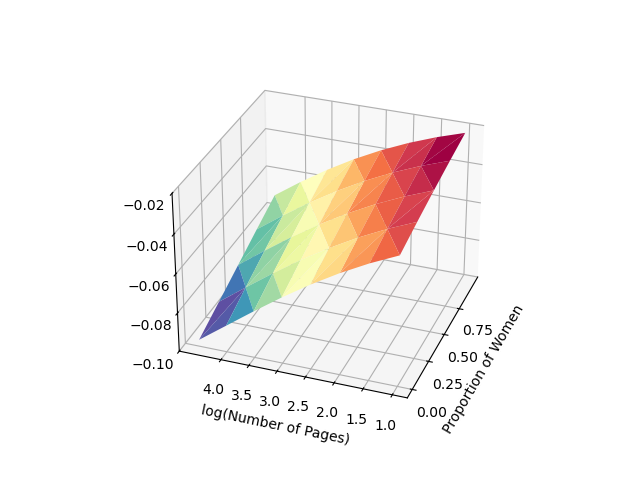

In [15]:
# Showing the graph
from IPython.display import Image
Image("../figures/Margins3d.png")